In [1]:
# Set environmental variables with google service credentials
import os
%env GOOGLE_APPLICATION_CREDENTIALS=/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json
print(os.getenv('GOOGLE_APPLICATION_CREDENTIALS'))

env: GOOGLE_APPLICATION_CREDENTIALS=/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json
/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json


In [2]:
# import necessary libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from google.cloud import bigquery

bqclient = bigquery.Client()

In [3]:
# Test BQ Connect
def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

implicit()

[]


In [4]:
# Download query results.
store_rfm = """
SELECT 
    store_name,
    SUM(sale_dollars) AS total_sales,
    COUNT(invoice_and_item_number) AS transaction_count,
    EXTRACT(DAY FROM (CURRENT_DATE() - MIN(date))) AS tenure,
    EXTRACT(DAY FROM (CURRENT_DATE() - MAX(date))) AS days_since_recent_sale
FROM `bigquery-public-data.iowa_liquor_sales.sales`
GROUP BY store_name
"""

store_rfm = (
    bqclient.query(store_rfm)
    .result()
    .to_dataframe(
        create_bqstorage_client=True,
    )
)

In [5]:
store_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2807 entries, 0 to 2806
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   store_name              2807 non-null   object 
 1   total_sales             2807 non-null   float64
 2   transaction_count       2807 non-null   int64  
 3   tenure                  2807 non-null   int64  
 4   days_since_recent_sale  2807 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 109.8+ KB


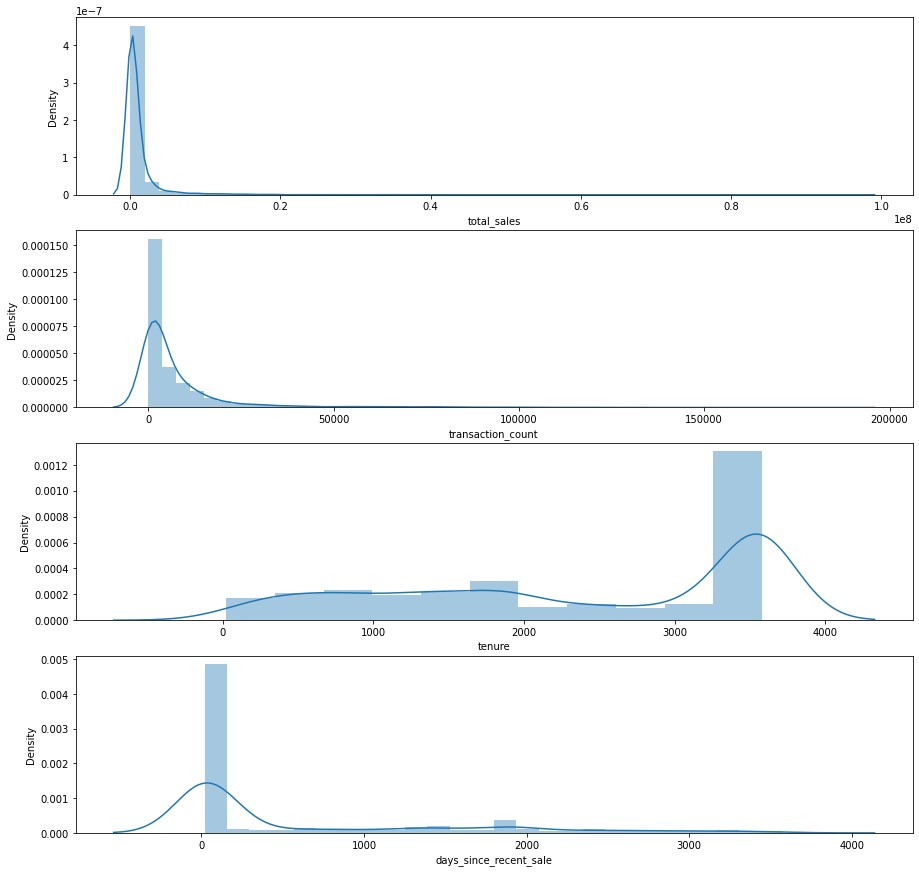

In [6]:
# Plot RFM distributions
plt.figure(figsize=(15,15))

plt.subplot(4, 1, 1); sns.distplot(store_rfm['total_sales'])
plt.subplot(4, 1, 2); sns.distplot(store_rfm['transaction_count'])
plt.subplot(4, 1, 3); sns.distplot(store_rfm['tenure'])
plt.subplot(4, 1, 4); sns.distplot(store_rfm['days_since_recent_sale'])
plt.show()

In [7]:
# Apply Log Transformation
days_since_recent_sale_log = np.log(store_rfm['days_since_recent_sale'])
transaction_count_log = np.log(store_rfm['transaction_count'])
total_sales_log = np.log(store_rfm['total_sales'])
tenure_log = np.log(store_rfm['tenure'])

## Standardizing mean and standard deviation

In [8]:
store_rfm_log = pd.DataFrame(
    {
        'days_since_recent_sale_log': days_since_recent_sale_log,
        'transaction_count_log': transaction_count_log,
        'total_sales_log': total_sales_log,
        'tenure_log': tenure_log
    }
)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(store_rfm_log)
store_rfm_log_norm = scaler.transform(store_rfm_log)

store_rfm_cleaned = pd.DataFrame(store_rfm_log_norm)
store_rfm_cleaned.describe().round(2)

,0,1,2,3
count,2807.00,2807.00,2807.00,2807.00
mean,0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00
min,-0.83,-4.46,-5.03,-5.09
25%,-0.78,-0.65,-0.60,-0.43
50%,-0.65,0.02,0.00,0.38
75%,1.19,0.74,0.66,0.78
max,1.87,2.52,3.36,0.78


## Plotting Number of Clusters Against Within-Cluster Sum-of-Squared-Errors (SSE)

In [10]:
from sklearn.cluster import KMeans

# Fit KMeans and calculate SSE for each *k*
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(store_rfm_cleaned)
    sse[k] = kmeans.inertia_
    
# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
# Choose k=4 and fit data set to k-means model
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(store_rfm_cleaned)

cluster_labels = kmeans.labels_
data_process_k4 = store_rfm.assign(Cluster = cluster_labels)

data_process_k4.groupby(['Cluster']).agg({
    'days_since_recent_sale': 'mean',
    'transaction_count': 'mean',
    'total_sales': 'mean',
    'tenure': ['mean', 'count']
}).round(0)

days_since_recent_sale transaction_count total_sales  tenure      
                          mean              mean        mean    mean count
Cluster                                                                   
0                         41.0           23064.0   3505604.0  3252.0   709
1                         38.0            2593.0    275683.0  1926.0   763
2                       1679.0            5920.0    553582.0  3194.0   614
3                         45.0             529.0     64870.0   478.0   448
4                       1864.0             298.0     26590.0  2296.0   273

- Cluster 0  
High sales volume and transaction volume and also on average the 2nd longest tenured stores in the database

- Cluster 1  
The "youngest" store in the database with much lower total sales volume compared to cluster 0 and lower transaction counts

- Cluster 2  
Low sales and transactions, last sale was made >1.8k days ago with long tenure (likely have been closed)

- Cluster 3  
Similarly high number of days since last sale >1.6k days ago but higher sales volume and transaction count than 2 and 3

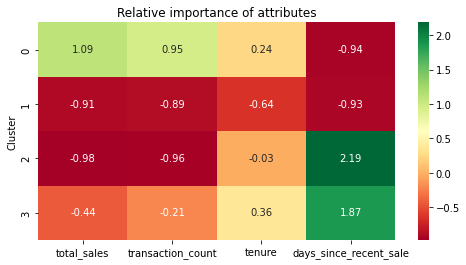

In [ ]:
# Calculate average RFM values for each cluster
cluster_avg = data_process_k4.groupby(['Cluster']).mean()

# Calculate average RFM values for the total customer population
population_avg = store_rfm.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 4))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()